# Overview

Simple demo with flu model with "toy" (not necessarily realistic or finalized) parameters

We go over
- How to set up subpopulation models and metapopulation models.
- How to run accept-reject algorithm.
- How to run experiments to organize output of multiple replications. 

# Imports

In [1]:
# Misc: suppress SSE4.2 deprecation warnings
# This is not an error, just a warning about future hardware compatibility (not relevant in general)
import os
os.environ["MKL_DEBUG_CPU_TYPE"] = "5" 

from pathlib import Path
import numpy as np
import pandas as pd

# Import city-level transmission base components module
import clt_toolkit as clt

# Import flu model module, which contains customized subclasses
import flu_core as flu

import json

# Reading Input Files

In [2]:
# Note that this can be cumbersome due to the complexity of the model 
# Users may prefer to create the model inputs or even the models themselves in a separate .py file and import them! 

# Obtain path to folder with JSON input files
base_path = clt.utils.PROJECT_ROOT / "flu_instances" / "texas_input_files"

# Get filepaths
compartments_epi_metrics_init_vals_filepath = base_path / "init_vals.json"
subpop_params_filepath = base_path / "common_subpop_params.json"
mixing_params_filepath = base_path / "mixing_params.json"
simulation_settings_filepath = base_path / "simulation_settings.json"

calendar_df = pd.read_csv(base_path / "school_work_calendar.csv", index_col=0)
humidity_df = pd.read_csv(base_path / "absolute_humidity_austin_2023_2024.csv", index_col=0)
vaccines_df = pd.read_csv(base_path / "daily_vaccines_constant.csv", index_col=0)
mobility_modifier_df = pd.read_csv(base_path / "mobility_modifier.csv", index_col=0)

schedules_info = flu.FluSubpopSchedules(absolute_humidity=humidity_df,
                                        flu_contact_matrix=calendar_df,
                                        daily_vaccines=vaccines_df,
                                        mobility_modifier=mobility_modifier_df)

# Read in files as dictionaries and dataframes.
# Note that we can also create these dictionaries directly
#   rather than reading from a predefined input data file.
state = clt.make_dataclass_from_json(compartments_epi_metrics_init_vals_filepath,
                                     flu.FluSubpopState)
params = clt.make_dataclass_from_json(subpop_params_filepath, flu.FluSubpopParams)
mixing_params = clt.make_dataclass_from_json(mixing_params_filepath, flu.FluMixingParams)
settings = clt.make_dataclass_from_json(simulation_settings_filepath, flu.SimulationSettings)

# Create two independent bit generators
bit_generator = np.random.MT19937(88888)
jumped_bit_generator = bit_generator.jumped(1)

# Creating Subpopulation Models

In [3]:
# Create two subpopulation models, one for the north
#   side of the city and one for the south side of the city
# In this case, these two (toy) subpopulations have the
#   same demographics, initial compartment and epi metric values,
#   fixed parameters, and school-work calendar.
# If we wanted the "north" subpopulation and "south"
#   subpopulation to have different aforementioned values,
#   we could read in two separate sets of files -- one
#   for each subpopulation.
north = flu.FluSubpopModel(state,
                           params,
                           settings,
                           np.random.Generator(bit_generator),
                           schedules_info,
                           name="north")

south = flu.FluSubpopModel(state,
                           params,
                           settings,
                           np.random.Generator(jumped_bit_generator),
                           schedules_info,
                           name="south")

# If a metapopulation model has N subpopulations that have most of their parameters in common,
#    users can make a JSON file with common parameters, and N smaller JSON files with
#    parameters that are specific to each subpopulation.
# We recommend using `clt_toolkit / utils` functions `updated_dataclass()` and `updated_dict()` for this.

# Modifying Parameters

In [4]:
# We can also manually change a fixed parameter value
#   after we have created a SubpopModel -- like so...
# Note that this is quite a large and unrealistic value of
#   beta_baseline, but we'll use this to create
#   a dramatic difference between the two subpopulations.
south.params = clt.updated_dataclass(south.params, {"beta_baseline": 10})

# The structure of the code allows us to access
#   the current state and fixed parameters of each
#   subpopulation model.
# For example, here we print out the fixed parameter
#   value for beta_baseline for the "south" subpopulation.
print(south.params.beta_baseline)

10


# Create Metapopulation Model

In [5]:
# Combine two subpopulations into one metapopulation model (travel model)
flu_demo_model = flu.FluMetapopModel([north, south],
                                     mixing_params)

# Simulation and Analysis

In [6]:
# Simulate for 50 days
flu_demo_model.simulate_until_day(50)

# Get the current real date of the simulation and the
#   current simulation day
print(flu_demo_model.current_simulation_day)
print(flu_demo_model.current_real_date)

50
2022-09-27


In [7]:
# Simulate for another 50 days, from where we last left off
flu_demo_model.simulate_until_day(100)

# We can "unpack" our flu model and access the current state
#   of each subpopulation -- here's an example with the "north"
#   subpopulation -- this is the state after we have simulated
#   our 100 days.
print(flu_demo_model.north.state)

# This is equivalent to calling `flu_demo_model.subpop_models.north.state`.
# Under the hood, CLT Toolkit uses "attribute delegation" to make the syntax easier and avoid nested attribute calls.

FluSubpopState(S=array([[ 251802.],
       [ 409855.],
       [1285933.],
       [ 568912.],
       [ 686520.]]), E=array([[ 140050.],
       [ 447477.],
       [1045912.],
       [ 393032.],
       [ 289883.]]), IP=array([[ 19001.],
       [ 60687.],
       [141849.],
       [ 53307.],
       [ 39323.]]), ISR=array([[ 40066.],
       [128010.],
       [299111.],
       [112329.],
       [ 81880.]]), ISH=array([[  80.],
       [ 106.],
       [ 472.],
       [ 360.],
       [2118.]]), IA=array([[ 19879.],
       [ 63492.],
       [148419.],
       [ 55777.],
       [ 41153.]]), HR=array([[ 127.],
       [ 166.],
       [ 750.],
       [ 541.],
       [3213.]]), HD=array([[ 41.],
       [ 36.],
       [ 41.],
       [ 41.],
       [291.]]), R=array([[ 1442963.],
       [ 4517187.],
       [10639131.],
       [ 4018480.],
       [ 3027168.]]), D=array([[7.0000e+00],
       [0.0000e+00],
       [1.3980e+03],
       [2.2370e+03],
       [2.3467e+04]]), M=array([[0.86944384],
       [0.8929

In [8]:
# Remember that we can easily access the objects that
#   make up our subpopulation model -- here's an
#   example of accessing the "north" subpopulation's
#   compartments.
# See API references for more attribute access syntax.
print(flu_demo_model.subpop_models.north.compartments)

#0. 'S':   <clt_toolkit.base_components.Compartment object at 0x121eb13d0>
#1. 'E':   <clt_toolkit.base_components.Compartment object at 0x103e38990>
#2. 'IP':  <clt_toolkit.base_components.Compartment object at 0x1227ae650>
#3. 'ISR': <clt_toolkit.base_components.Compartment object at 0x1227d2290>
#4. 'ISH': <clt_toolkit.base_components.Compartment object at 0x1227d2750>
#5. 'IA':  <clt_toolkit.base_components.Compartment object at 0x1227d2b10>
#6. 'HR':  <clt_toolkit.base_components.Compartment object at 0x1227d3fd0>
#7. 'HD':  <clt_toolkit.base_components.Compartment object at 0x1227d22d0>
#8. 'R':   <clt_toolkit.base_components.Compartment object at 0x1227d2990>
#9. 'D':   <clt_toolkit.base_components.Compartment object at 0x1179b2090>


In [9]:
# Here's the current state of the "S" compartment for the "north" subpopulation
print(flu_demo_model.north.S.current_val)

# Again, due to attribute delegation, this syntax is equivalent to
# flu_demo_model.subpop_models.north.compartments.S.current_val

[[ 251802.]
 [ 409855.]
 [1285933.]
 [ 568912.]
 [ 686520.]]


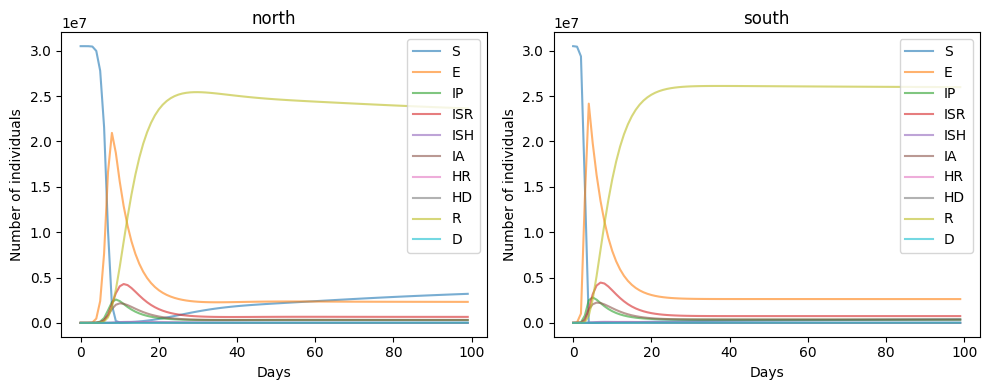

In [10]:
# Generate simple compartment history plot for flu model
clt.plot_metapop_basic_compartment_history(flu_demo_model)

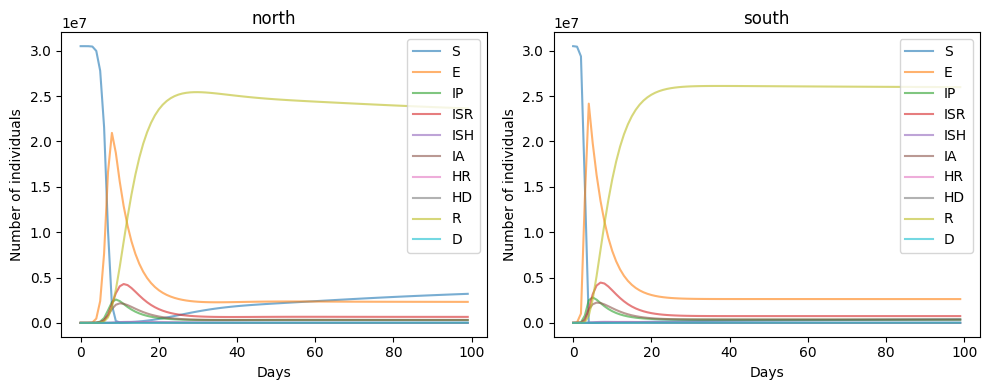

In [11]:
# Reset the simulation
# Note -- does NOT reset the RNG! Only clears each object's
#   history, resets the simulation day/date to the starting
#   day/date, and returns state variables to their initial values.
flu_demo_model.reset_simulation()

# Set school and work contact matrices to zero matrices for both
#   subpopulations and demonstrate that this removes the calendar-induced
#   periodicity.
num_age_groups = flu_demo_model.subpop_models.north.params.num_age_groups

for subpop_model in flu_demo_model.subpop_models.values():
    subpop_model.params = clt.updated_dataclass(subpop_model.params,
                                                {"school_contact_matrix": np.zeros((num_age_groups, num_age_groups)),
                                                 "work_contact_matrix": np.zeros((num_age_groups, num_age_groups))})

flu_demo_model.simulate_until_day(100)

clt.plot_metapop_basic_compartment_history(flu_demo_model)

# Accept Reject

In [12]:
# Distinct RNG for random sampling
accept_reject_RNG = np.random.Generator(bit_generator.jumped(2))

# See `clt_toolkit / sampling / sample_uniform_metapop_params` docstring for `sampling_spec` details.
# Here, we want to sample `IP_relative_inf`, which is a scalar, from a Uniform[1,3] distribution.
# We want this value to be the same across all subpopulations.
sampling_spec = {"all_subpop": {"IP_relative_inf": clt.UniformSamplingSpec(1, 3, "scalar")}}

# Here we will create some artificial "target admits".
# We want sampled parameters that generate hospital admits close to these target admits.
flu_demo_model.reset_simulation()
flu_demo_model.modify_simulation_settings({"transition_variables_to_save": ["ISH_to_HR", "ISH_to_HD"]})
flu_demo_model.simulate_until_day(50)

# Transition variables' histories get saved for each timestep.
# We use this function convert per-timestep hospital admits to per-day hospital admits.
target_admits = clt.aggregate_daily_tvar_history(flu_demo_model, ["ISH_to_HR", "ISH_to_HD"])

# Perform accept reject -- see docstring for more details and additional parameters 
#    (that are not shown because set to defaults).
# If target admits is over 50 days, then we need to simulate 50 days for the accept-reject algorithm as well.
flu.accept_reject_admits(flu_demo_model,
                         accept_reject_RNG,
                         sampling_spec,
                         target_admits,
                         num_days = 50,
                         target_accepted_reps = 2,
                         max_reps = 20)

In [13]:
# This command-line function shows the `JSON` files that `accept_reject_admits` generates.
!ls *accepted*

subpop_north_rep_1_accepted_sample_params.json
subpop_north_rep_1_accepted_state.json
subpop_north_rep_2_accepted_sample_params.json
subpop_north_rep_2_accepted_state.json
subpop_south_rep_1_accepted_sample_params.json
subpop_south_rep_1_accepted_state.json
subpop_south_rep_2_accepted_sample_params.json
subpop_south_rep_2_accepted_state.json


In [14]:
# Here's the state of the "north" subpopulation in accepted replication #1, at simulation time 50.
# We can load this into a `FluSubpopParams` instance and use it to create a new `FluSubpopModel` instance in the future.
with open("subpop_north_rep_1_accepted_state.json", "r") as f:
    north_rep_1_state = json.load(f) 
print(north_rep_1_state)

{'S': [[196038.0], [319719.0], [1005890.0], [444869.0], [532088.0]], 'E': [[137044.0], [445276.0], [1035562.0], [387361.0], [277725.0]], 'IP': [[18509.0], [60288.0], [140033.0], [52347.0], [37423.0]], 'ISR': [[38593.0], [126546.0], [292927.0], [109195.0], [76002.0]], 'ISH': [[133.0], [163.0], [796.0], [559.0], [3473.0]], 'IA': [[19228.0], [62874.0], [145778.0], [54438.0], [38771.0]], 'HR': [[275.0], [342.0], [1627.0], [1135.0], [7130.0]], 'HD': [[41.0], [34.0], [41.0], [83.0], [620.0]], 'R': [[1504149.0], [4611774.0], [10938980.0], [4152966.0], [3201568.0]], 'D': [[6.0], [0.0], [1382.0], [2063.0], [20216.0]], 'M': [[0.4655963502218194], [0.4816538085835662], [0.4737386543074666], [0.4694688938637291], [0.4507093341751248]], 'MV': [[0.0004532901200728371], [0.0009065802401456742], [0.0013598703602185113], [0.0018131604802913484], [0.002266450600364188]], 'absolute_humidity': 0.013399104, 'flu_contact_matrix': [[1.41415435, 2.37024572, 3.83356137, 0.71327459, 0.35347632], [1.00728934, 10

In [15]:
# Here are the SAMPLED parameters of the "north" and "south" subpop models in accepted replication #1.
# Recall that we specified that this sampled value should be the same across all subpopulations -- and we confirm this below.

with open("subpop_north_rep_1_accepted_sample_params.json", "r") as f:
    north_rep_1_params = json.load(f) 
print(north_rep_1_params)

with open("subpop_south_rep_1_accepted_sample_params.json", "r") as f:
    south_rep_1_params = json.load(f) 
print(south_rep_1_params)

{'IP_relative_inf': 1.35}
{'IP_relative_inf': 1.35}


# Experiments

In [16]:
# Create an experiment class to record "HR", "HD", and "D" compartment values
experiment = clt.Experiment(model = flu_demo_model, 
                            state_variables_to_record = ["HR", "HD", "D"], 
                            database_filename = "flu_demo_H_D_results.db")

# Run the simulation for 10 independent replications, for 100 days, and save the values of
#    "HR", "HD", and "D" every 7 days. Save the results in a CSV file. 
experiment.run_static_inputs(num_reps = 10, 
                             simulation_end_day = 100, 
                             days_between_save_history = 7, 
                             results_filename = "flu_demo_H_D_results.csv")

In [17]:
# Here's the CSV we just created -- pretty nifty! :) 
H_D_results_df = pd.read_csv("flu_demo_H_D_results.csv", index_col=0)

H_D_results_df.head()

,subpop_name,state_var_name,age_group,risk_group,rep,timepoint,value
0,north,HR,0,0,0,7,1.0
1,north,HR,1,0,0,7,4.0
2,north,HR,2,0,0,7,20.0
3,north,HR,3,0,0,7,10.0
4,north,HR,4,0,0,7,50.0


In [18]:
# `run_static_inputs` also creates a SQL database with the large-scale output from our experiment.
!ls *.db*

flu_demo_H_D_results.db


In [19]:
# Build dataframe of "HR" state based on experiment run above (simulated 100 days, state saved every 7 days).
# See `get_state_var_df()` docstring for details. 
# Because we do not specify `subpop_name`, `age_group`, or `risk_group`, 
#     compartment values are summed across subpopulations, ages, and risk groups.
experiment.get_state_var_df(state_var_name = "HR",
                            results_filename = "flu_demo_aggregated_H_results.csv")

timepoint,7,14,21,28,35,42,49,56,63,70,77,84,91,98,100
rep,,,,,,,,,,,,,,,
0,16424.0,162787.0,188702.0,113579.0,59369.0,33389.0,22221.0,17345.0,14927.0,13371.0,12271.0,11462.0,10756.0,10150.0,10019.0
1,16424.0,162787.0,188702.0,113579.0,59369.0,33389.0,22221.0,17345.0,14927.0,13371.0,12271.0,11462.0,10756.0,10150.0,10019.0
2,16424.0,162787.0,188702.0,113579.0,59369.0,33389.0,22221.0,17345.0,14927.0,13371.0,12271.0,11462.0,10756.0,10150.0,10019.0
3,16424.0,162787.0,188702.0,113579.0,59369.0,33389.0,22221.0,17345.0,14927.0,13371.0,12271.0,11462.0,10756.0,10150.0,10019.0
4,16424.0,162787.0,188702.0,113579.0,59369.0,33389.0,22221.0,17345.0,14927.0,13371.0,12271.0,11462.0,10756.0,10150.0,10019.0
5,16424.0,162787.0,188702.0,113579.0,59369.0,33389.0,22221.0,17345.0,14927.0,13371.0,12271.0,11462.0,10756.0,10150.0,10019.0
6,16424.0,162787.0,188702.0,113579.0,59369.0,33389.0,22221.0,17345.0,14927.0,13371.0,12271.0,11462.0,10756.0,10150.0,10019.0
7,16424.0,162787.0,188702.0,113579.0,59369.0,33389.0,22221.0,17345.0,14927.0,13371.0,12271.0,11462.0,10756.0,10150.0,10019.0
8,16424.0,162787.0,188702.0,113579.0,59369.0,33389.0,22221.0,17345.0,14927.0,13371.0,12271.0,11462.0,10756.0,10150.0,10019.0
